In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path

# run in kernel: base_env_apifish

In [2]:
sys.path.append(os.path.abspath(Path('../pipeline/src').resolve()))
sys.path.append(os.path.abspath(Path('../pipeline').resolve()))

In [3]:
#sys.path.append(os.path.abspath('/home/jacques/Documents/FISH/Data_analysis/pipeline_smfish_in_apifish/pipeline_lnp_apifish_for_opera/src'))
#sys.path.append(os.path.abspath("/home/jacques/Documents/FISH/Data_analysis/pipeline_smfish_in_apifish/pipeline_lnp_apifish_for_opera"))

In [4]:
list_im_path = [Path('/media/PBI_big_data/rna-imaging/data/smFISH-optimization/clearing/2023-04-26_ClearingTestConcentration/temp_focus_figures/e2_1.tif'),
                Path('/media/PBI_big_data/rna-imaging/data/smFISH-optimization/clearing/2023-04-26_ClearingTestConcentration/temp_focus_figures/e2_2.tif'),
                Path('/media/PBI_big_data/rna-imaging/data/smFISH-optimization/clearing/2023-04-26_ClearingTestConcentration/temp_focus_figures/e2_3.tif'),
                Path('/media/PBI_big_data/rna-imaging/data/smFISH-optimization/clearing/2023-04-26_ClearingTestConcentration/temp_focus_figures/e5_1.tif'),
                Path('/media/PBI_big_data/rna-imaging/data/smFISH-optimization/clearing/2023-04-26_ClearingTestConcentration/temp_focus_figures/e5_2.tif'),
                Path('/media/PBI_big_data/rna-imaging/data/smFISH-optimization/clearing/2023-04-26_ClearingTestConcentration/temp_focus_figures/e5_3.tif'),
                Path('/media/PBI_big_data/rna-imaging/data/smFISH-optimization/clearing/2023-04-26_ClearingTestConcentration/temp_focus_figures/e8_1.tif'),
                Path('/media/PBI_big_data/rna-imaging/data/smFISH-optimization/clearing/2023-04-26_ClearingTestConcentration/temp_focus_figures/e8_2.tif'),
                Path('/media/PBI_big_data/rna-imaging/data/smFISH-optimization/clearing/2023-04-26_ClearingTestConcentration/temp_focus_figures/e8_3.tif'),]

In [5]:
list_stacks = [io.imread(el) for el in list_im_path]

In [5]:
# first a simple max projection

In [6]:
list_im_mip = [np.max(el, axis=0) for el in list_stacks]

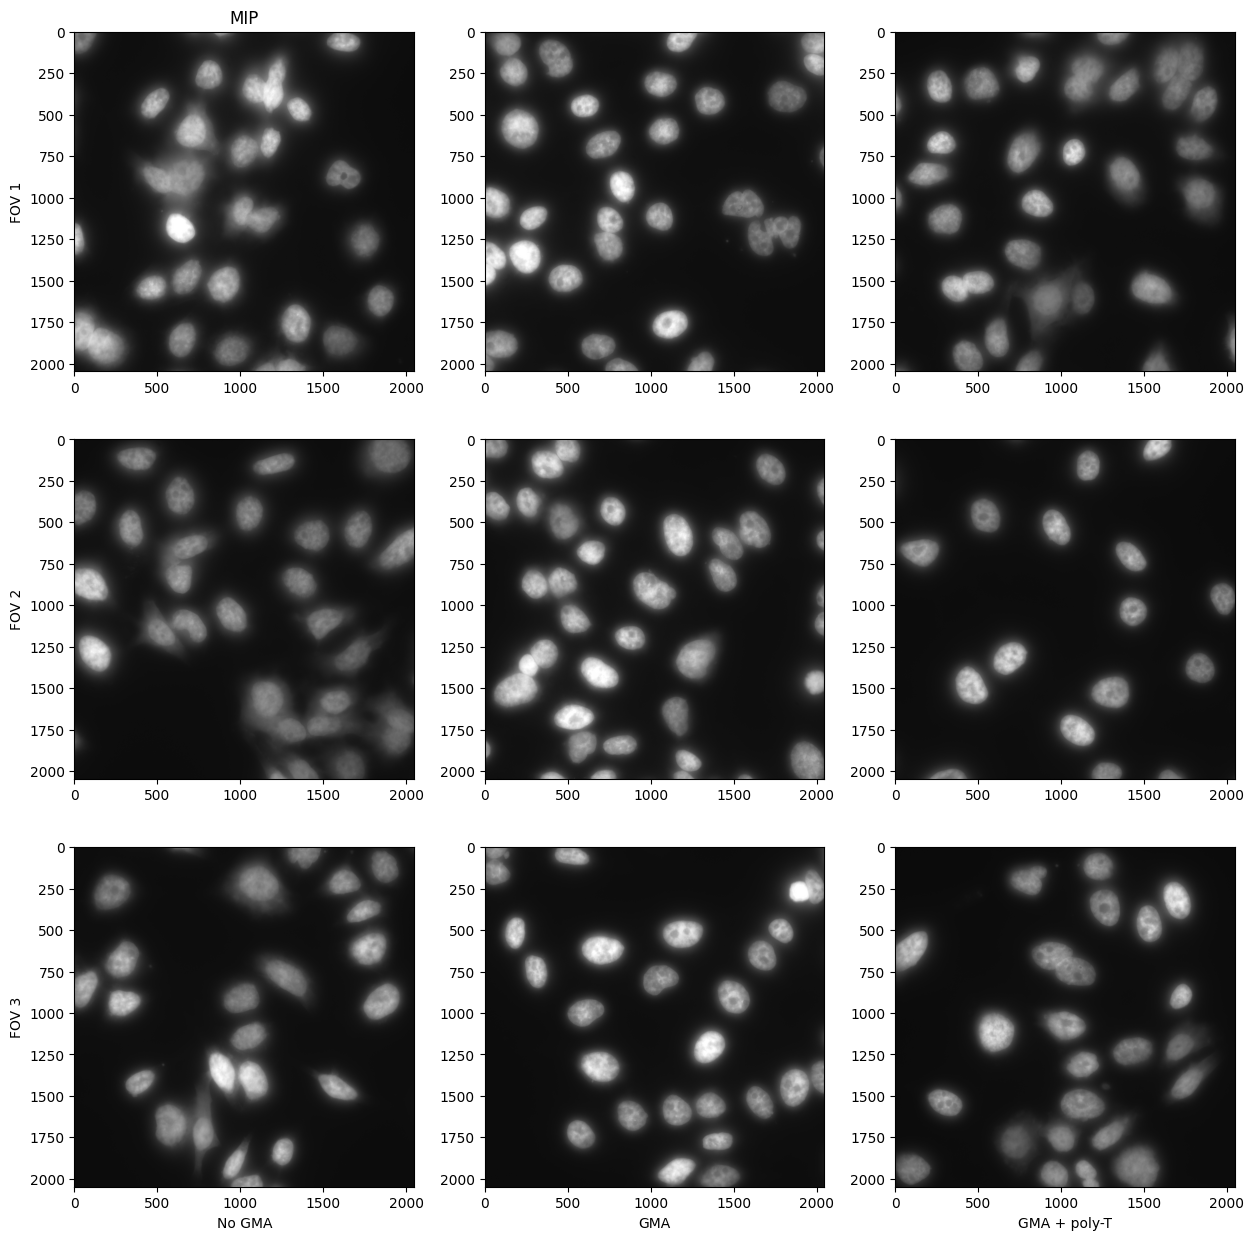

In [7]:
ind_col = [(0,0),(1,0),(2,0),(0,1),(1,1),(2,1),(0,2),(1,2),(2,2)]

fig, ax = plt.subplots(3,3,figsize=(15,15))
for ind, pair in enumerate(ind_col):
    line, col  = pair
    ax[line, col].imshow(list_im_mip[ind], cmap='gray', vmin=0, vmax=2900)

ax[0, 0].set_ylabel("FOV 1");
ax[1, 0].set_ylabel("FOV 2");
ax[2, 0].set_ylabel("FOV 3");

ax[2, 0].set_xlabel("No GMA");
ax[2, 1].set_xlabel("GMA");
ax[2, 2].set_xlabel("GMA + poly-T");
ax[0, 0].set_title("MIP");

In [9]:
# initial segmentation:

In [8]:
from segmentation.refine_seg import Segmentation
sg = Segmentation()

In [9]:
list_segm_mip = []
diameter      = 60
for im in list_im_mip:
    im_deb = sg.deblur_cellpose(im, diameter=diameter)
    masks  = sg.segment_cellpose_cyto3(im_deb, diameter=diameter)
    list_segm_mip.append(masks)

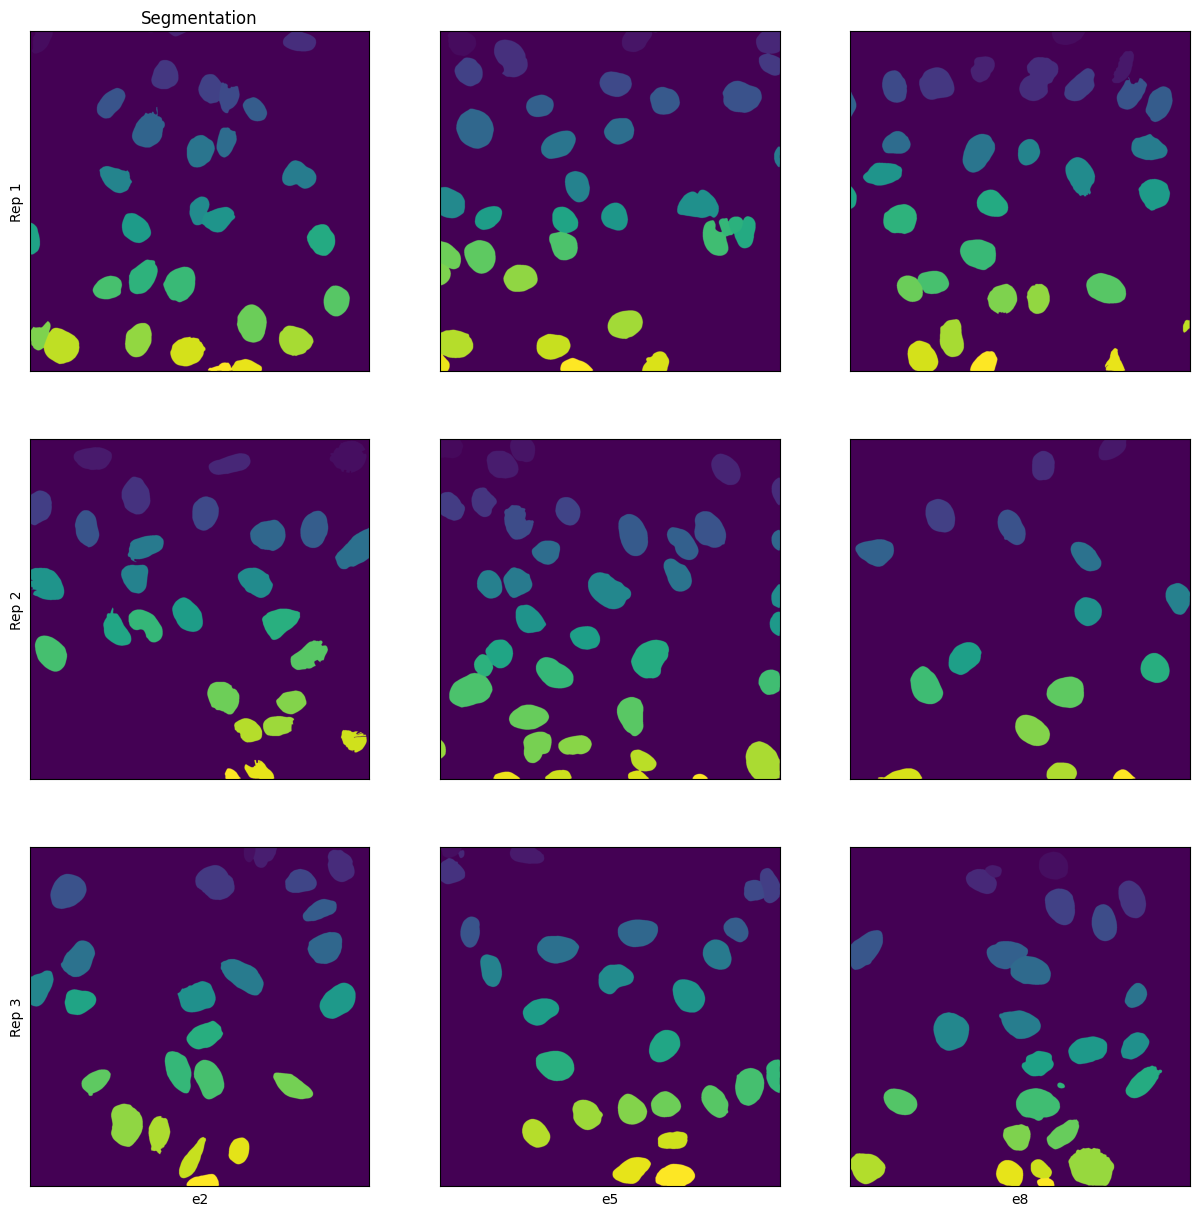

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for ind, pair in enumerate(ind_col):
    line, col = pair
    ax[line, col].imshow(list_segm_mip[ind])
    ax[line, col].set_xticks([])
    ax[line, col].set_yticks([])

ax[0, 0].set_ylabel("Rep 1");
ax[1, 0].set_ylabel("Rep 2");
ax[2, 0].set_ylabel("Rep 3");

ax[2, 0].set_xlabel("e2");
ax[2, 1].set_xlabel("e5");
ax[2, 2].set_xlabel("e8");

ax[0, 0].set_title("Segmentation");

In [11]:
# measure focus along stack :
from max_projection.max_proj_2D_3D import MaxProj
mp = MaxProj()

def measure_focus_along_stack(focus: np.ndarray, mask: np.ndarray):
    meas = []
    for focus_temp in focus:
        meas.append(np.mean(focus_temp[mask]))
    return meas    

In [12]:
measures_focus    = []
index_max_focus   = []
neighborhood_size = 31
for ind, masks in enumerate(list_segm_mip):
    labels_fov   = np.unique(masks)[1:]
    measures_focus_per_cell = []
    ind_max_focus_per_cell  = []
    focus_3D     = mp.compute_focus_opt(list_stacks[ind], neighborhood_size=neighborhood_size)
    for lab in labels_fov:
        masks_c_temp = lab == masks
        meas  = measure_focus_along_stack(focus_3D, masks_c_temp)
        measures_focus_per_cell.append(meas)
        ind_max_focus_per_cell.append(np.argmax(meas))
        
    measures_focus.append(measures_focus_per_cell)
    index_max_focus.append(ind_max_focus_per_cell)

ind_median_focus = [int(np.median(el)) for el in index_max_focus]

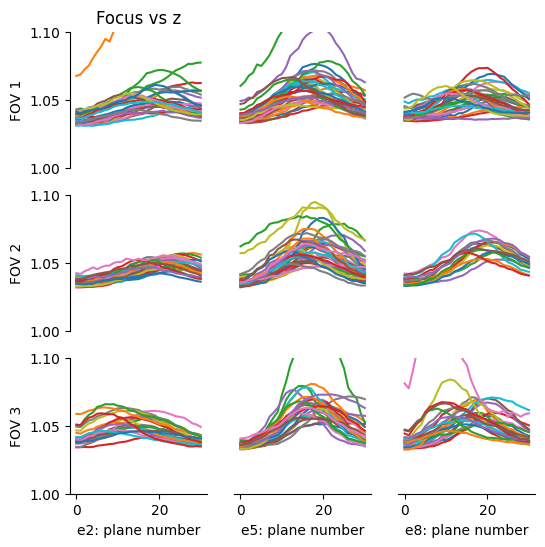

In [14]:
fig, ax = plt.subplots(3,3,figsize=(6,6))
for ind, pair in enumerate(ind_col):
    line, col  = pair   
    for m in measures_focus[ind]:
        ax[line, col].plot(m)

    ax[line, col].set_ylim([1, 1.10])
    
    ax[line, col].spines['top'].set_visible(False)
    ax[line, col].spines['right'].set_visible(False)

    if line != 2:
        ax[line, col].spines['bottom'].set_visible(False)
        ax[line, col].set_xticks([])

    if col != 0:
        ax[line, col].spines['left'].set_visible(False)
        ax[line, col].set_yticks([])

ax[0, 0].set_ylabel("FOV 1");
ax[1, 0].set_ylabel("FOV 2");
ax[2, 0].set_ylabel("FOV 3");

ax[2, 0].set_xlabel("e2: plane number");
ax[2, 1].set_xlabel("e5: plane number");
ax[2, 2].set_xlabel("e8: plane number");
ax[0, 0].set_title("Focus vs z");

plt.savefig('Focus_vs_z.svg')

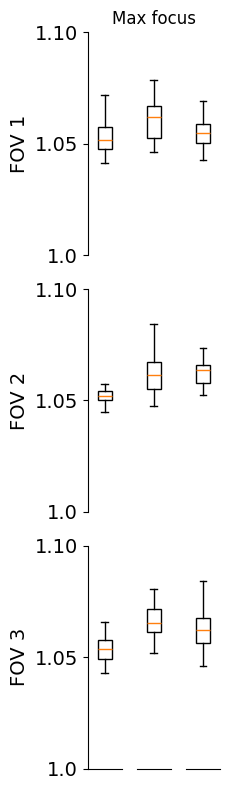

In [15]:
fig, ax = plt.subplots(3,3,figsize=(3*0.8, 8))
for ind, pair in enumerate(ind_col):
    line, col  = pair
    max_foc    = []
    for m in measures_focus[ind]:
        max_foc.append(np.max(m))   
    bp = ax[line, col].boxplot(max_foc, vert=True, patch_artist=True, showfliers=False, whis=1.5, widths=0.4)

    for box in bp['boxes']:
        box.set(facecolor='none') 
    
    ax[line, col].set_xticks([])
    ax[line, col].set_ylim([1, 1.10])

    ax[line, col].spines['top'].set_visible(False)
    ax[line, col].spines['right'].set_visible(False)

    if line != 2:
        ax[line, col].spines['bottom'].set_visible(False)

    if col == 0:
        ax[line, col].set_yticks([1.0, 1.05, 1.1])
        ax[line, col].set_yticklabels(['1.0', '1.05', '1.10'], fontsize=14)
    else:
        ax[line, col].set_yticks([]) 
        ax[line, col].set_yticklabels([])
        ax[line, col].spines['left'].set_visible(False)

ax[0, 0].set_ylabel("FOV 1", fontsize=14);
ax[1, 0].set_ylabel("FOV 2",fontsize=14);
ax[2, 0].set_ylabel("FOV 3", fontsize=14);


ax[2, 0].set_xlabel("") #"Without GMA",fontsize=14, rotation= 90);
ax[2, 1].set_xlabel("") #With GMA",fontsize=14, rotation= 90);
ax[2, 2].set_xlabel("") #With GMA + poly-T",fontsize=14, rotation= 90);

ax[0, 1].set_title("Max focus");

plt.tight_layout()


plt.savefig('Max_focus.svg')

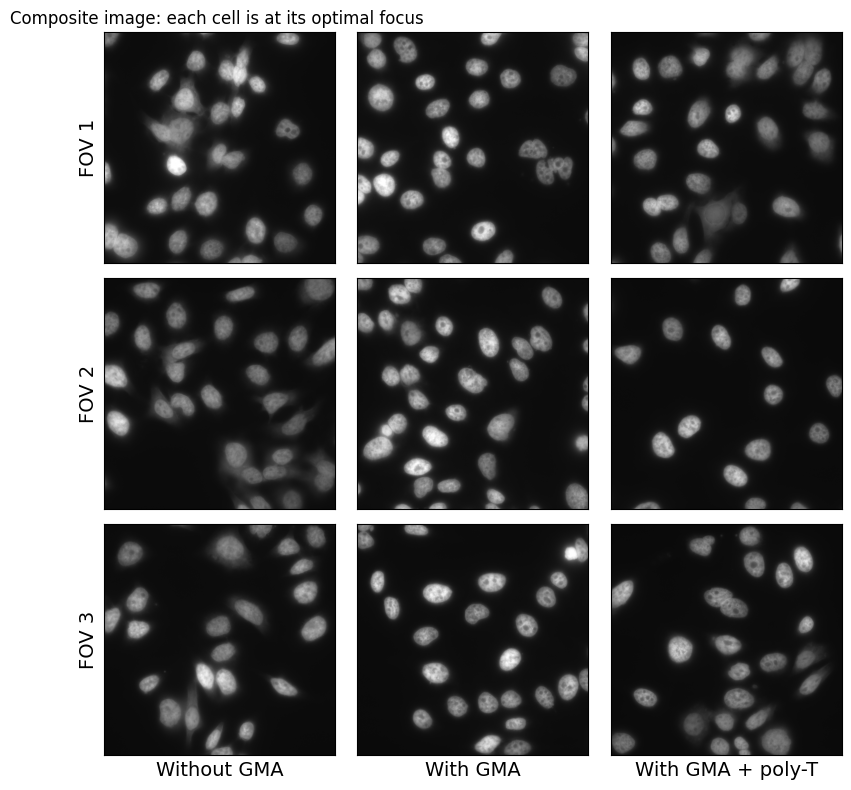

In [16]:
fig, ax = plt.subplots(3,3,figsize=(8,8))

for ind, masks in enumerate(list_segm_mip):
    line, col  = ind_col[ind]     
    im_to_fill = np.zeros_like(masks)
    labels_fov = np.unique(masks)[1:]
    masks_inv  = np.logical_not(masks > 0)
    for ind_lab, lab in enumerate(labels_fov):
        masks_c_temp = lab == masks
        ind_star = index_max_focus[ind][ind_lab]
        im_to_fill[masks_c_temp] = list_stacks[ind][ind_star, masks_c_temp]
    ind_star_inv = ind_median_focus[ind]
    im_to_fill[masks_inv] = list_stacks[ind][ind_star_inv, masks_inv]

    ax[line, col].imshow(im_to_fill, cmap='gray', vmin=0, vmax=2900)
    ax[line, col].set_xticks([])
    ax[line, col].set_yticks([])
    
ax[0, 0].set_ylabel("FOV 1",fontsize=14);
ax[1, 0].set_ylabel("FOV 2", fontsize=14);
ax[2, 0].set_ylabel("FOV 3", fontsize=14);

ax[2, 0].set_xlabel("Without GMA",fontsize=14);
ax[2, 1].set_xlabel("With GMA",fontsize=14);
ax[2, 2].set_xlabel("With GMA + poly-T",fontsize=14);
ax[0, 0].set_title("Composite image: each cell is at its optimal focus ");    

plt.tight_layout()

plt.savefig('Composite_image.svg')